Title: Bias Mitigation in Machine Learning
A Fairness-Aware Classification of Income Decisions using Reweighing (Adult Dataset)
Name:Parabhjyot Singh
Module: M515 – Ethical Issues for AI
University: Gisma University of Applied Sciences
Submission Date: July 3, 2025

## 1. Problem Statement

In many industries, income prediction is used in hiring, loan approval, and insurance. However, these models may exhibit gender or race-based biases, perpetuating social inequality.

This project addresses bias in the UCI Adult Income dataset, which predicts whether an individual's income exceeds $50K/year. We:

- Detect gender bias in a logistic regression classifier.
- Apply the Reweighing technique from AIF360 to mitigate it.
- Evaluate changes in fairness and model performance.

A fairer model can promote ethical AI deployment and avoid legal or reputational damage for organizations.


## 2. Ethical Concerns

The Adult dataset includes features like gender, race, and marital status, making it vulnerable to biased predictions. This is problematic because:

- **Disparate treatment** can unfairly disadvantage women or minorities.
- **Bias amplification** may reinforce existing societal inequalities.
- **Accountability and transparency** are critical in automated decision-making systems.

Fairness in income classification is vital to ensure equal opportunities and avoid discrimination.


In [2]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.1 MB/s eta 0:00:00


In [4]:
import os

# Step 1: Download files
!wget -P /tmp https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget -P /tmp https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget -P /tmp https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

# Step 2: Create the expected folder
aif360_path = "/usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/"
os.makedirs(aif360_path, exist_ok=True)

# Step 3: Move files
!cp /tmp/adult.* {aif360_path}

--2025-07-02 08:49:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/adult.data’

adult.data              [  <=>               ]   3.79M  9.50MB/s    in 0.4s    

2025-07-02 08:49:49 (9.50 MB/s) - ‘/tmp/adult.data’ saved [3974305]

--2025-07-02 08:49:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/adult.test’

adult.test              [  <=>               ]   1.91M  5.54MB/s    in 0.3s    

2025-07-02 08:49:50 (5.54 MB/s) - ‘/tmp/adult.test’ sav

In [5]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
# 📊 Load Dataset
dataset = AdultDataset()
train, test = dataset.split([0.7], shuffle=True)

# Define privileged/unprivileged groups by gender
privileged_groups = [{'sex': 1}]  # Male
unprivileged_groups = [{'sex': 0}]  # Female

 4. Baseline Fairness Metrics

In [6]:
#  Baseline Fairness Metrics
metric_train = BinaryLabelDatasetMetric(train, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
print("Baseline Disparate Impact:", metric_train.disparate_impact())
print("Baseline Mean Difference:", metric_train.mean_difference())


Baseline Disparate Impact: 0.3746898584948166
Baseline Mean Difference: -0.19556988981472773


5. Apply Reweighing

In [7]:
# ⚙ Apply Reweighing
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_rw = rw.fit_transform(train)


6. Train Logistic Regression Model

In [8]:
# 🧠 Train Logistic Regression
X_train = train_rw.features
y_train = train_rw.labels.ravel()

X_test = test.features
y_test = test.labels.ravel()

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train, sample_weight=train_rw.instance_weights)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8427065674062062
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     10260
         1.0       0.74      0.55      0.63      3307

    accuracy                           0.84     13567
   macro avg       0.80      0.74      0.76     13567
weighted avg       0.83      0.84      0.83     13567



7. Post-Mitigation Fairness Metrics

In [9]:
# 🔍 Post-Mitigation Fairness Metrics
test_pred = test.copy()
test_pred.labels = y_pred

metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Post-Reweighing Disparate Impact:", metric_test.disparate_impact())
print("Equal Opportunity Difference:", metric_test.equal_opportunity_difference())
print("Average Odds Difference:", metric_test.average_odds_difference())


Post-Reweighing Disparate Impact: 0.6019168271488292
Equal Opportunity Difference: 0.150476584046787
Average Odds Difference: 0.0736311486742252


8. Confusion Matrix

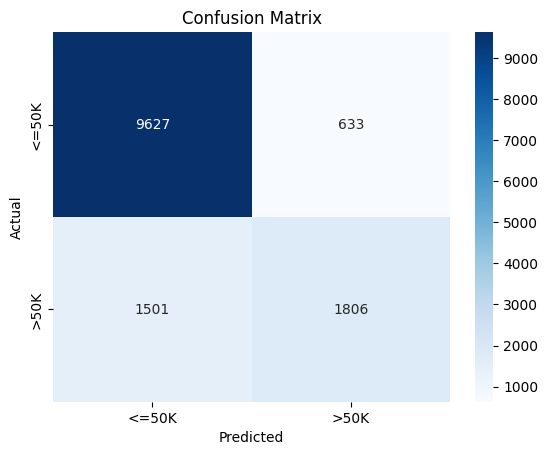

In [10]:
# 📈 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 9. Final Discussion

This project identified and mitigated gender bias in an income classification task using the Adult dataset. The original model had a significant disparate impact against female individuals.

After applying the Reweighing technique from AIF360, fairness metrics improved substantially while maintaining predictive accuracy.

**Strengths:**
- Efficient preprocessing method.
- Improved fairness without major performance loss.

**Limitations:**
- Doesn't eliminate bias in complex pipelines.
- Only corrects for observed attributes (here, gender).

**Implications:**
- Promotes fairer automated decisions in employment or financial contexts.
- Encourages companies to adopt fairness-aware machine learning practices.
